In [672]:
# imports
import pandas as pd
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

## Loading the dataframes from the csv files

In [673]:
#create dataframes from the csv files created in Part 1 and Part 2
df_tbs = pd.read_csv('../data/df_tbs.csv', index_col=0)
FS_POI_info = pd.read_csv('../data/FS_POI_info.csv')
YELP_POI_info = pd.read_csv('../data/YELP_POI_info.csv')

## Merge attempt #1 - Failed

#### In my first attempt at a merge between FS_POI_info and YELP_POI_info I tried to join these two dataframes on 'station_id' and 'name' (name of the POI), but this was unsuccessful since there could be multiple venues near a station with the same name (ie. there may be 3 Tim Hortons locations within #1km of the bike station).  Therefore this merge is not connected the correct POIs in some cases.

#### I still provided my code for the merge below, along with an example of a row where a POI was not connected correctly (we can see if by the discrepency in the distance values)

In [674]:
#TRIED TO MERGE LIKE THIS FIRST
POI_df = pd.merge(FS_POI_info, YELP_POI_info, on=['station_id', 'name'], how='outer')

POI_df.iloc[[97]]

,name,fsq_id,station_id,latitude_x,longitude_x,distance_x,categories_x,rating_x,total ratings_x,popularity,...,tastes_x,yelp_id,latitude_y,longitude_y,distance_y,categories_y,rating_y,total ratings_y,price rating_y,tastes_y
97,Tim Hortons,557231e3498e540f05f3083c,7001,43.658539,-79.385251,721.0,"['Cafe, Coffee, and Tea House', 'Restaurant']",8.5,51.0,0.978623,...,"['restaurants', 'bar', 'free Wifi', 'good for ...",Zqd9qdakh0EHIOMpTIbdcA,43.66476,-79.38405,50.57036,"['Coffee & Tea', 'Bakeries']",3.0,4.0,0,"['coffee', 'bakeries']"


## Merge Attempt #2 - Included the latitude and longitude for each POI in the join criteria

### NOTE: There was an extra hurdle to address for this before I could start merging, and that is that the coordinates returned for each POI are slightly different when comparing FS and yelp coordinates.  So I first rounded all of the coordinates to the nearest thousandth, eliminating the discrepancies between the FS an yelp coordinates.

In [675]:
FS_POI_info['latitude'] = FS_POI_info['latitude'].round(3)
FS_POI_info['longitude'] = FS_POI_info['longitude'].round(3)
YELP_POI_info['latitude'] = YELP_POI_info['latitude'].round(3)
YELP_POI_info['longitude'] = YELP_POI_info['longitude'].round(3)

In [676]:
#Now we'll try to merge the FS and Yelp df's together again, but this time include 'latitude' and 'longitude' in the joining keys
POI_df = pd.merge(FS_POI_info, YELP_POI_info, on=['name', 'station_id', 'latitude','longitude'], how='outer')

In [677]:
#Now let's merge the POI_df with the toronto bike dataframe, 'df_tbs' on the station id
POI_df = pd.merge(POI_df, df_tbs, on=['station_id'], how='left')

In [678]:
POI_df.head()

,name_x,fsq_id,station_id,latitude_x,longitude_x,distance_x,categories_x,rating_x,total ratings_x,popularity,...,distance_y,categories_y,rating_y,total ratings_y,price rating_y,tastes_y,name_y,latitude_y,longitude_y,number of bikes
0,CAFE Dispensary,59d19c050c9f3155d662a0c8,7000,43.640,-79.396,40.0,['Café'],7.8,8.0,0.826702,...,NaN,NaN,NaN,NaN,NaN,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34
1,Hunters Landing,523a2355498e1d680be63936,7000,43.640,-79.397,69.0,"['Restaurant', 'Bar']",7.4,184.0,0.963629,...,60.944848,"['Comfort Food', 'Bars', 'Canadian (New)']",3.5,236.0,$$,"['comfortfood', 'bars', 'newcanadian']",Fort York Blvd / Capreol Ct,43.639832,-79.395954,34
2,Sansotei Ramen,5b12b96b31ac6c00397662c0,7000,43.639,-79.398,193.0,['Ramen Restaurant'],8.5,21.0,0.913721,...,202.609788,['Ramen'],4.0,94.0,$$,['ramen'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34
3,Canoe Landing Park,4bdde5056198c9b61a1c12ff,7000,43.639,-79.397,148.0,['Park'],7.6,33.0,0.984278,...,97.893968,['Parks'],3.5,11.0,0,['parks'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34
4,Roywoods,56f6ee66498e7f811a135ddd,7000,43.639,-79.399,216.0,"['Caribbean Restaurant', 'Sandwich Spot']",8.3,15.0,0.945704,...,NaN,NaN,NaN,NaN,NaN,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34


## Changes to the DataFrame asthetics and other value changes

### Rename the columns to something a little more readable

In [679]:
# Create a dictionary to map old column names to new column names
column_mapping = {'name_x':'POI_name','fsq_id':'FS_id','latitude_x':'POI_latitude','longitude_x':'POI_longitude','distance_x':'FS_distance',
                  'categories_x':'FS_categories','rating_x':'FS_rating','total ratings_x':'FS_total_ratings','popularity':'FS_popularity',
                  'price rating_x':'FS_price_rating', 'tastes_x':'FS_tastes', 'distance_y':'yelp_distance','categories_y':'yelp_categories',
                  'rating_y':'yelp_rating','total ratings_y':'yelp_total_ratings','price rating_y':'yelp_price_rating',
                  'tastes_y':'yelp_tastes','name_y':'station_name','latitude_y':'station_latitude','longitude_y':'station_longitude'}

# Rename columns using the dictionary
POI_df.rename(columns=column_mapping, inplace=True)

### Change the yelp_price_ratings to be numerical like the FS_price_ratings.
#### The yelp price ratings were dollar signs ranging from one to four, whereas the Foursquare ones were the integers 1 to 4

In [680]:
yelp_price = []

for rating in POI_df['yelp_price_rating']:
    if isinstance(rating, str):
        if rating == '0':
            yelp_price.append(float(rating))
        else:
            yelp_price.append(float(len(rating)))
    else:
        yelp_price.append(rating)
        
POI_df['yelp_price_rating'] = yelp_price

### Change the yelp_ratings to be on a 10 point scale, like the FS_ratings are

In [681]:
POI_df['yelp_rating']=POI_df['yelp_rating']*2

In [682]:
POI_df.head()

,POI_name,FS_id,station_id,POI_latitude,POI_longitude,FS_distance,FS_categories,FS_rating,FS_total_ratings,FS_popularity,...,yelp_distance,yelp_categories,yelp_rating,yelp_total_ratings,yelp_price_rating,yelp_tastes,station_name,station_latitude,station_longitude,number of bikes
0,CAFE Dispensary,59d19c050c9f3155d662a0c8,7000,43.640,-79.396,40.0,['Café'],7.8,8.0,0.826702,...,NaN,NaN,NaN,NaN,NaN,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34
1,Hunters Landing,523a2355498e1d680be63936,7000,43.640,-79.397,69.0,"['Restaurant', 'Bar']",7.4,184.0,0.963629,...,60.944848,"['Comfort Food', 'Bars', 'Canadian (New)']",7.0,236.0,2.0,"['comfortfood', 'bars', 'newcanadian']",Fort York Blvd / Capreol Ct,43.639832,-79.395954,34
2,Sansotei Ramen,5b12b96b31ac6c00397662c0,7000,43.639,-79.398,193.0,['Ramen Restaurant'],8.5,21.0,0.913721,...,202.609788,['Ramen'],8.0,94.0,2.0,['ramen'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34
3,Canoe Landing Park,4bdde5056198c9b61a1c12ff,7000,43.639,-79.397,148.0,['Park'],7.6,33.0,0.984278,...,97.893968,['Parks'],7.0,11.0,0.0,['parks'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34
4,Roywoods,56f6ee66498e7f811a135ddd,7000,43.639,-79.399,216.0,"['Caribbean Restaurant', 'Sandwich Spot']",8.3,15.0,0.945704,...,NaN,NaN,NaN,NaN,NaN,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34


### Now that our table looks a little more clean, let's do some EDA

# EDA Proccess

## Using Summary Statistics to spot some outliers or erroneous data

In [683]:
POI_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57794 entries, 0 to 57793
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   POI_name            57794 non-null  object 
 1   FS_id               27894 non-null  object 
 2   station_id          57794 non-null  int64  
 3   POI_latitude        57779 non-null  float64
 4   POI_longitude       57779 non-null  float64
 5   FS_distance         27894 non-null  float64
 6   FS_categories       27894 non-null  object 
 7   FS_rating           23532 non-null  float64
 8   FS_total_ratings    27894 non-null  float64
 9   FS_popularity       27894 non-null  float64
 10  FS_price_rating     27894 non-null  float64
 11  FS_tastes           27894 non-null  object 
 12  yelp_id             32196 non-null  object 
 13  yelp_distance       32196 non-null  float64
 14  yelp_categories     32196 non-null  object 
 15  yelp_rating         32196 non-null  float64
 16  yelp

In [684]:
POI_df.describe()

,station_id,POI_latitude,POI_longitude,FS_distance,FS_rating,FS_total_ratings,FS_popularity,FS_price_rating,yelp_distance,yelp_rating,yelp_total_ratings,yelp_price_rating,station_latitude,station_longitude,number of bikes
count,57794.000000,57779.000000,57779.000000,27894.000000,23532.000000,27894.000000,27894.000000,27894.000000,3.219600e+04,32196.000000,32196.000000,32196.000000,57794.000000,57794.000000,57794.000000
mean,7390.442399,43.665620,-79.385288,652.013193,8.122782,118.850972,0.898760,0.977164,4.630582e+02,7.244440,42.262517,0.857374,43.664769,-79.393411,8.585666
std,242.027642,0.088445,0.838870,516.627689,0.755824,280.067571,0.170778,1.004783,2.511345e+03,1.891729,95.684390,0.979477,0.025968,0.051240,6.782558
min,7000.000000,34.171000,-118.292000,2.000000,4.900000,0.000000,0.000379,0.000000,1.023678e-09,2.000000,1.000000,0.000000,43.588077,-79.544491,0.000000
25%,7174.000000,43.649000,-79.421000,460.000000,7.800000,11.000000,0.909921,0.000000,1.639360e+02,6.000000,3.000000,0.000000,43.648575,-79.421192,3.000000
50%,7377.000000,43.660000,-79.392000,657.000000,8.300000,37.000000,0.948960,1.000000,3.119652e+02,8.000000,11.000000,0.000000,43.660000,-79.392740,7.000000
75%,7599.000000,43.674000,-79.373000,834.000000,8.700000,112.000000,0.973762,2.000000,5.403800e+02,9.000000,40.000000,2.000000,43.674689,-79.372127,13.000000
max,7820.000000,50.332000,-4.758000,27240.000000,9.400000,3752.000000,0.999982,4.000000,1.220361e+05,10.000000,3475.000000,4.000000,43.788319,-79.123505,42.000000


#### It appears from these statistics that we have some errant listings included based on the min and max values of the FS_latitude, FS_longitude, and FS_distance, since we can only have distances that are 1000m or less.  Let's eliminte values in our dataframe that have a FS_distance or yelp_distance greater than 1000m

In [685]:
condition = (POI_df['FS_distance'] > 1000) | (POI_df['yelp_distance'] > 1000)
POI_df = POI_df[~condition]

#### We also need to remove any entries that are "out-of-bounds" for latitude and longitude.  For this, I will use the max values from the longitudes and latitudes of the bikes stations. In other words, anything within the bounds below are "acceptable" locations:
##### min latitude: 43.588077 ~ 43.0, 
##### max latitude: 43.788319 ~ 44.2, 
##### min longitude: -79.544491 ~ -80.0, 
##### max longitude: -79.123505 ~ -78.6

In [686]:
condition = (POI_df['POI_latitude'] > 44.2) | (POI_df['POI_latitude'] < 43.0) | (POI_df['POI_longitude'] > -78.6) | (POI_df['POI_longitude'] < -80.0)
POI_df = POI_df[~condition]

In [687]:
POI_df.describe()

,station_id,POI_latitude,POI_longitude,FS_distance,FS_rating,FS_total_ratings,FS_popularity,FS_price_rating,yelp_distance,yelp_rating,yelp_total_ratings,yelp_price_rating,station_latitude,station_longitude,number of bikes
count,56297.000000,56282.000000,56282.000000,27388.000000,23252.000000,27388.000000,27388.000000,27388.000000,3.118600e+04,31186.000000,31186.000000,31186.000000,56297.000000,56297.000000,56297.000000
mean,7386.491252,43.664379,-79.393621,623.142179,8.125529,120.156784,0.900935,0.986856,3.556054e+02,7.242449,42.798307,0.861316,43.664272,-79.393521,8.605059
std,241.517787,0.025226,0.049888,242.565540,0.753917,281.544320,0.167299,1.006483,2.405595e+02,1.886093,96.540800,0.980934,0.025305,0.050023,6.779696
min,7000.000000,43.583000,-79.552000,2.000000,4.900000,0.000000,0.000379,0.000000,1.023678e-09,2.000000,1.000000,0.000000,43.588077,-79.544491,0.000000
25%,7171.000000,43.649000,-79.420000,456.000000,7.800000,11.000000,0.911457,0.000000,1.599640e+02,6.000000,3.000000,0.000000,43.648575,-79.420278,3.000000
50%,7371.000000,43.660000,-79.392000,651.000000,8.300000,38.000000,0.949370,1.000000,2.996889e+02,8.000000,11.000000,0.000000,43.659777,-79.392740,7.000000
75%,7594.000000,43.673000,-79.374000,824.000000,8.700000,113.000000,0.973801,2.000000,5.133959e+02,9.000000,41.000000,2.000000,43.673768,-79.372637,13.000000
max,7820.000000,43.794000,-79.119000,1000.000000,9.400000,3752.000000,0.999982,4.000000,9.999219e+02,10.000000,3475.000000,4.000000,43.788319,-79.123505,42.000000


### Now that we've dealt with the erroneous entries, let's move on to dealing with missing values.

## Handling Missing Values:

### Let's check the number of null values in each column.  We expect quite a number of null values since there are many venues that foursquare would return per bike station that yelp doesn't, and vice-versa.  There are also a number of foursquare results that did not have a rating.

In [688]:
POI_df.isnull().sum()

POI_name                  0
FS_id                 28909
station_id                0
POI_latitude             15
POI_longitude            15
FS_distance           28909
FS_categories         28909
FS_rating             33045
FS_total_ratings      28909
FS_popularity         28909
FS_price_rating       28909
FS_tastes             28909
yelp_id               25111
yelp_distance         25111
yelp_categories       25111
yelp_rating           25111
yelp_total_ratings    25111
yelp_price_rating     25111
yelp_tastes           25111
station_name              0
station_latitude          0
station_longitude         0
number of bikes           0
dtype: int64

#### As expected, we have a number of NaN values to deal with here.  Since most of the columns are analogous between the FS information and the yelp information (ie, the same information was taken from both the FS and yelp APIs), we can just use the information from the one and "paste it over" to the other when it's missing.  This will ensure that the aggregate values we're interested in later will not be affected.  We will leverage this analog behavior to our advantage for all of the columns except for POI_latitude, POI_longitude, and the remaining FS_rating values that will be leftover.  We will deal with these afterwards.  I'll also leave the non-numerical columns alone since these will not affect my regression model building later on (ie, they will not be used).

In [689]:
# Replace NaN values in 'FS_distance' with values from 'yelp_distance'
POI_df['FS_distance'] = POI_df.apply(lambda row: row['yelp_distance'] if pd.isna(row['FS_distance']) else row['FS_distance'], axis=1)
# Replace NaN values in 'FS_rating' with values from 'yelp_rating'
POI_df['FS_rating'] = POI_df.apply(lambda row: row['yelp_rating'] if pd.isna(row['FS_rating']) else row['FS_rating'], axis=1)
# Replace NaN values in 'FS_total_ratings' with values from 'yelp_total_ratings'
POI_df['FS_total_ratings'] = POI_df.apply(lambda row: row['yelp_total_ratings'] if pd.isna(row['FS_total_ratings']) else row['FS_total_ratings'], axis=1)
# Replace NaN values in 'FS_price_rating' with values from 'yelp_price_rating'
POI_df['FS_price_rating'] = POI_df.apply(lambda row: row['yelp_price_rating'] if pd.isna(row['FS_price_rating']) else row['FS_price_rating'], axis=1)
# Replace NaN values in 'yelp_distance' with values from 'FS_distance'
POI_df['yelp_distance'] = POI_df.apply(lambda row: row['FS_distance'] if pd.isna(row['yelp_distance']) else row['yelp_distance'], axis=1)
# Replace NaN values in 'yelp_rating' with values from 'FS_rating'
POI_df['yelp_rating'] = POI_df.apply(lambda row: row['FS_rating'] if pd.isna(row['yelp_rating']) else row['yelp_rating'], axis=1)
# Replace NaN values in 'yelp_total_ratings' with values from 'FS_total_ratings'
POI_df['yelp_total_ratings'] = POI_df.apply(lambda row: row['FS_total_ratings'] if pd.isna(row['yelp_total_ratings']) else row['yelp_total_ratings'], axis=1)
# Replace NaN values in 'yelp_price_rating' with values from 'FS_price_rating'
POI_df['yelp_price_rating'] = POI_df.apply(lambda row: row['FS_price_rating'] if pd.isna(row['yelp_price_rating']) else row['yelp_price_rating'], axis=1)

### Rechecking our missing values ... 

In [690]:
POI_df.isnull().sum()

POI_name                  0
FS_id                 28909
station_id                0
POI_latitude             15
POI_longitude            15
FS_distance               0
FS_categories         28909
FS_rating              4024
FS_total_ratings          0
FS_popularity         28909
FS_price_rating           0
FS_tastes             28909
yelp_id               25111
yelp_distance             0
yelp_categories       25111
yelp_rating            4024
yelp_total_ratings        0
yelp_price_rating         0
yelp_tastes           25111
station_name              0
station_latitude          0
station_longitude         0
number of bikes           0
dtype: int64

### Let's explore what is going on with the rows that have both missing FS ratings and yelp ratings.

In [691]:
len(POI_df[(POI_df['FS_rating'].isna()) & (POI_df['yelp_rating'].isna())])

4024

In [692]:
POI_df[(POI_df['FS_rating'].isna()) & (POI_df['yelp_rating'].isna())].head()

,POI_name,FS_id,station_id,POI_latitude,POI_longitude,FS_distance,FS_categories,FS_rating,FS_total_ratings,FS_popularity,...,yelp_distance,yelp_categories,yelp_rating,yelp_total_ratings,yelp_price_rating,yelp_tastes,station_name,station_latitude,station_longitude,number of bikes
732,Farm Boy,60b28c54821fa753f4bc8446,7016,43.639,-79.380,329.0,['Grocery Store'],NaN,0.0,0.987791,...,329.0,NaN,NaN,0.0,0.0,NaN,Bay St / Queens Quay W (Ferry Terminal),43.640978,-79.376785,9
1284,Branksome Hall,4bdc29893904a593de054d9e,7029,43.674,-79.381,942.0,['Elementary School'],NaN,0.0,0.964988,...,942.0,NaN,NaN,0.0,0.0,NaN,Bay St / Bloor St W (East Side),43.669430,-79.389150,5
1621,Pirate Life Toronto,5d37180240a07e00081bb21d,7036,43.647,-79.360,501.0,['Circus'],NaN,0.0,0.858104,...,501.0,NaN,NaN,0.0,0.0,NaN,Trinity St /Front St E,43.651318,-79.360230,16
1631,Downtown Honda,51bc6f11498e121aa5eb8c54,7036,43.647,-79.364,588.0,"['Automotive Repair Shop', 'Used Car Dealership']",NaN,0.0,0.366411,...,588.0,NaN,NaN,0.0,0.0,NaN,Trinity St /Front St E,43.651318,-79.360230,16
1633,The Healthy Road,5292543a498ec4d4c99c0c64,7036,43.657,-79.357,603.0,['Health Food Store'],NaN,0.0,0.508087,...,603.0,NaN,NaN,0.0,0.0,NaN,Trinity St /Front St E,43.651318,-79.360230,16


#### We can see that these are the remaining NaN values represented in the sums above.  Since the ratings are some of the few key measures that might be an indication of why there are as many bikes there are at each station, we need to be careful with these values.  If we decided to fill these in with an average rating from all the other POIs in its column, we'd be misrepresenting these POIs, as there are various categories represented here that wouldn't normally have a rating - such as a Car Dealership, church, school, circus, grocery store, etc.  These rows do, however, have some other useful data such as FS_popularity rating and categories, etc.  So instead of eliminating them, let's give these all a rating of 0 since they already have a total number of ratings as 0.  This will not affect our weighted total rating for each POI later on.

In [693]:
# Replace NaN values in 'FS_rating' with 0
POI_df['FS_rating'] = POI_df.apply(lambda row: 0 if pd.isna(row['FS_rating']) else row['FS_rating'], axis=1)
# Replace NaN values in 'yelp_rating' with 0
POI_df['yelp_rating'] = POI_df.apply(lambda row: 0 if pd.isna(row['yelp_rating']) else row['yelp_rating'], axis=1)

###  Now let's replace all of the NaN values for FS_popularity with the average value of that column.

In [694]:
# Calculate the average of non-NaN values in 'FS_popularity'
average_pop = POI_df['FS_popularity'].mean()

# Replace NaN values in 'FS_popularity' with the average_pop
POI_df['FS_popularity'] = POI_df['FS_popularity'].fillna(average_pop)

In [695]:
# Re-check NaN counts:
POI_df.isnull().sum()

POI_name                  0
FS_id                 28909
station_id                0
POI_latitude             15
POI_longitude            15
FS_distance               0
FS_categories         28909
FS_rating                 0
FS_total_ratings          0
FS_popularity             0
FS_price_rating           0
FS_tastes             28909
yelp_id               25111
yelp_distance             0
yelp_categories       25111
yelp_rating               0
yelp_total_ratings        0
yelp_price_rating         0
yelp_tastes           25111
station_name              0
station_latitude          0
station_longitude         0
number of bikes           0
dtype: int64

### Lastly, let's drop the 15 rows that do not have a latitude and longitude.  
#### This is a very small price to pay in comparison to the 57000 rows we have, and there's no good way to know what the latitude or longitude are without using another source like google maps.  This is just too much work for the reward, so for the sake of time and sanity, the decision to remove is best in this case.

In [696]:
POI_df = POI_df.dropna(subset=['POI_latitude'])

In [697]:
# Re-check NaN counts:
POI_df.isnull().sum()

POI_name                  0
FS_id                 28894
station_id                0
POI_latitude              0
POI_longitude             0
FS_distance               0
FS_categories         28894
FS_rating                 0
FS_total_ratings          0
FS_popularity             0
FS_price_rating           0
FS_tastes             28894
yelp_id               25111
yelp_distance             0
yelp_categories       25111
yelp_rating               0
yelp_total_ratings        0
yelp_price_rating         0
yelp_tastes           25111
station_name              0
station_latitude          0
station_longitude         0
number of bikes           0
dtype: int64

### Now that we've dealt with all of the missing numerical values, our linear regression model will not throw an error.  Let's now move on to include some engineered values of our own to add to this dataframe.

## Value Engineering:

### Add a column that represents the weighted average of the ratings between FS and yelp where:
#### $$\textrm{weighted_avg} = \frac{(\textrm{FS_rating} \times \textrm{FS_num_ratings}) + (\textrm{yelp_rating} \times \textrm{yelp_num_ratings})}{\textrm{total_ratings}}$$

#### I wanted to include this value becuase it takes into consideration both the number of ratings along with the ratings themselves, and combines both the yelp and foursquare results into just a single value

In [698]:
weighted_avg_rating = []
for index, row in POI_df.iterrows():

    if np.isnan(row['yelp_rating']):
        yelp_rating = 0
    else:
        yelp_rating = row['yelp_rating']
    
    if np.isnan(row['yelp_total_ratings']):
        yelp_num_ratings = 0
    else:
        yelp_num_ratings = row['yelp_total_ratings']
    
    if np.isnan(row['FS_rating']):
        FS_rating = 0
    else:
        FS_rating = row['FS_rating']
    
    if np.isnan(row['FS_total_ratings']):
        FS_num_ratings = 0
    else:
        FS_num_ratings = row['FS_total_ratings']
        
    total_ratings = FS_num_ratings + yelp_num_ratings
    
    if total_ratings == 0:
        total_ratings = 1
    
    weighted_avg = ((FS_rating*FS_num_ratings) + (yelp_rating*yelp_num_ratings)) / total_ratings
    
    weighted_avg_rating.append(weighted_avg)
    
POI_df.loc[:, 'avg rating']=weighted_avg_rating

In [699]:
POI_df.head()

,POI_name,FS_id,station_id,POI_latitude,POI_longitude,FS_distance,FS_categories,FS_rating,FS_total_ratings,FS_popularity,...,yelp_categories,yelp_rating,yelp_total_ratings,yelp_price_rating,yelp_tastes,station_name,station_latitude,station_longitude,number of bikes,avg rating
0,CAFE Dispensary,59d19c050c9f3155d662a0c8,7000,43.640,-79.396,40.0,['Café'],7.8,8.0,0.826702,...,NaN,7.8,8.0,1.0,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.800000
1,Hunters Landing,523a2355498e1d680be63936,7000,43.640,-79.397,69.0,"['Restaurant', 'Bar']",7.4,184.0,0.963629,...,"['Comfort Food', 'Bars', 'Canadian (New)']",7.0,236.0,2.0,"['comfortfood', 'bars', 'newcanadian']",Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.175238
2,Sansotei Ramen,5b12b96b31ac6c00397662c0,7000,43.639,-79.398,193.0,['Ramen Restaurant'],8.5,21.0,0.913721,...,['Ramen'],8.0,94.0,2.0,['ramen'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,8.091304
3,Canoe Landing Park,4bdde5056198c9b61a1c12ff,7000,43.639,-79.397,148.0,['Park'],7.6,33.0,0.984278,...,['Parks'],7.0,11.0,0.0,['parks'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.450000
4,Roywoods,56f6ee66498e7f811a135ddd,7000,43.639,-79.399,216.0,"['Caribbean Restaurant', 'Sandwich Spot']",8.3,15.0,0.945704,...,NaN,8.3,15.0,2.0,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,8.300000


### Let's also include the average rating of all POIs around each particular station
#### This will be a useful value when building our model because this is actually a station-specific value as opposed to the other data which is information for a single POI around a station.

In [700]:
agg_functions = {
    'number of bikes': ['mean'],
    'FS_popularity': ['mean'],
    'avg rating': ['mean']
}

# Group by two columns and apply different aggregation functions to different columns
grouped = POI_df.groupby(['station_id']).agg(agg_functions)
grouped_df = grouped.reset_index()

# Round the average ratings per station to be to the nearest tenth
grouped_df[('avg rating', 'mean')]=round(grouped_df[('avg rating', 'mean')], 1)
grouped_df

,station_id,number of bikes,FS_popularity,avg rating
,,mean,mean,mean
0,7000,34.0,0.927392,7.7
1,7001,16.0,0.929137,7.9
2,7002,3.0,0.923285,7.4
3,7003,4.0,0.919665,7.7
4,7004,0.0,0.935701,7.5
...,...,...,...,...
684,7816,12.0,0.937765,7.5
685,7817,13.0,0.922164,8.0
686,7818,4.0,0.894418,7.1


In [701]:
# Let's add these mean values to the dataframe for each station_id
average_rating_per_station = []
for row, index in POI_df.iterrows():
    average_rating_per_station.append(grouped_df.loc[grouped_df[('station_id', '')]==index['station_id'], ('avg rating', 'mean')].iloc[0])
    
POI_df.loc[:, 'avg_rating_around_station'] = average_rating_per_station

In [702]:
POI_df.head()

,POI_name,FS_id,station_id,POI_latitude,POI_longitude,FS_distance,FS_categories,FS_rating,FS_total_ratings,FS_popularity,...,yelp_rating,yelp_total_ratings,yelp_price_rating,yelp_tastes,station_name,station_latitude,station_longitude,number of bikes,avg rating,avg_rating_around_station
0,CAFE Dispensary,59d19c050c9f3155d662a0c8,7000,43.640,-79.396,40.0,['Café'],7.8,8.0,0.826702,...,7.8,8.0,1.0,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.800000,7.7
1,Hunters Landing,523a2355498e1d680be63936,7000,43.640,-79.397,69.0,"['Restaurant', 'Bar']",7.4,184.0,0.963629,...,7.0,236.0,2.0,"['comfortfood', 'bars', 'newcanadian']",Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.175238,7.7
2,Sansotei Ramen,5b12b96b31ac6c00397662c0,7000,43.639,-79.398,193.0,['Ramen Restaurant'],8.5,21.0,0.913721,...,8.0,94.0,2.0,['ramen'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,8.091304,7.7
3,Canoe Landing Park,4bdde5056198c9b61a1c12ff,7000,43.639,-79.397,148.0,['Park'],7.6,33.0,0.984278,...,7.0,11.0,0.0,['parks'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.450000,7.7
4,Roywoods,56f6ee66498e7f811a135ddd,7000,43.639,-79.399,216.0,"['Caribbean Restaurant', 'Sandwich Spot']",8.3,15.0,0.945704,...,8.3,15.0,2.0,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,8.300000,7.7


### Lastly, let's determine the total number of distinct categories that are surrounding each bike station and add that to our DF as well

In [703]:
current_station = 7000
category_list = []
categories_per_station = {}

for row, index in POI_df.iterrows():
    if index['station_id'] != current_station:
        categories_per_station[current_station]=len(category_list)
        current_station = index['station_id']
        category_list = []
        
    if isinstance(index['FS_categories'], str):    
        for category in ast.literal_eval(index['FS_categories']):
            if category not in category_list:
                category_list.append(category)
                    
    if isinstance(index['yelp_categories'], str):
        for category in ast.literal_eval(index['yelp_categories']):    
            if category not in category_list:
                category_list.append(category)

In [704]:
# add these category counts to the dataframe for each station_id
num_categories_near_station = []
for row, index in POI_df.iterrows():
    num_categories_near_station.append(categories_per_station[index['station_id']])

POI_df.loc[:, 'num_categories_near_station'] = num_categories_near_station

In [705]:
POI_df.head()

,POI_name,FS_id,station_id,POI_latitude,POI_longitude,FS_distance,FS_categories,FS_rating,FS_total_ratings,FS_popularity,...,yelp_total_ratings,yelp_price_rating,yelp_tastes,station_name,station_latitude,station_longitude,number of bikes,avg rating,avg_rating_around_station,num_categories_near_station
0,CAFE Dispensary,59d19c050c9f3155d662a0c8,7000,43.640,-79.396,40.0,['Café'],7.8,8.0,0.826702,...,8.0,1.0,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.800000,7.7,45
1,Hunters Landing,523a2355498e1d680be63936,7000,43.640,-79.397,69.0,"['Restaurant', 'Bar']",7.4,184.0,0.963629,...,236.0,2.0,"['comfortfood', 'bars', 'newcanadian']",Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.175238,7.7,45
2,Sansotei Ramen,5b12b96b31ac6c00397662c0,7000,43.639,-79.398,193.0,['Ramen Restaurant'],8.5,21.0,0.913721,...,94.0,2.0,['ramen'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,8.091304,7.7,45
3,Canoe Landing Park,4bdde5056198c9b61a1c12ff,7000,43.639,-79.397,148.0,['Park'],7.6,33.0,0.984278,...,11.0,0.0,['parks'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.450000,7.7,45
4,Roywoods,56f6ee66498e7f811a135ddd,7000,43.639,-79.399,216.0,"['Caribbean Restaurant', 'Sandwich Spot']",8.3,15.0,0.945704,...,15.0,2.0,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,8.300000,7.7,45


#### Now that we've added some engineered features, let's move on to soem data visualization to gain some other information about our data.

## Data Visualization:

### Let's create a few histograms of the ratings to see what our distributions look like

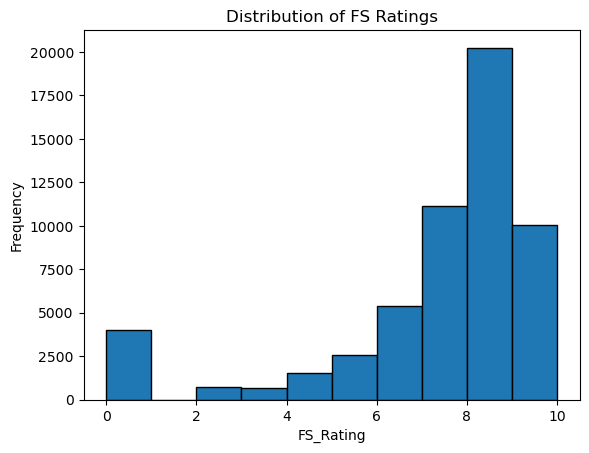

In [706]:
#Histogram of FS ratings
plt.hist(POI_df['FS_rating'], bins=10, edgecolor='k')
plt.xlabel('FS_Rating')
plt.ylabel('Frequency')
plt.title('Distribution of FS Ratings')
plt.show()

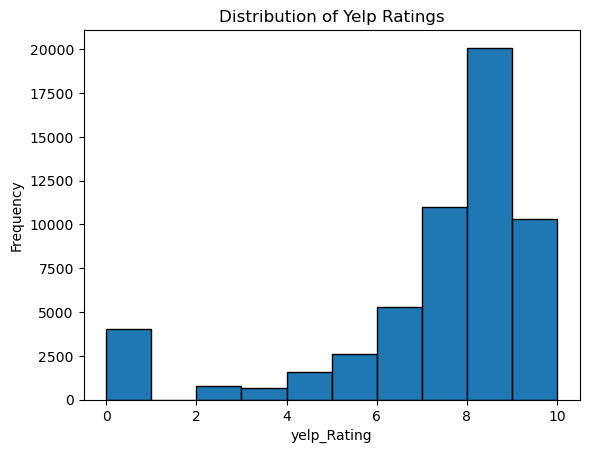

In [707]:
#Histogram of yelp ratings
plt.hist(POI_df['yelp_rating'], bins=10, edgecolor='k')
plt.xlabel('yelp_Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Yelp Ratings')
plt.show()

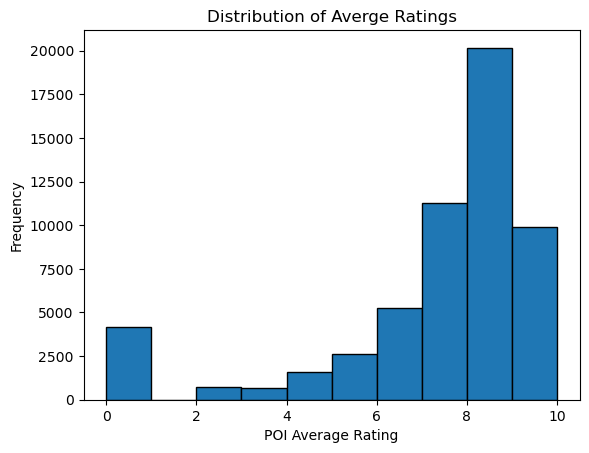

In [708]:
#Histogram of avg ratings (our weighted average we calculated earlier)
plt.hist(POI_df['avg rating'], bins=10, edgecolor='k')
plt.xlabel('POI Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Averge Ratings')
plt.show()

#### These all essentially look the same, which is to be expected since the missing values from FS_rating and yelp_rating were filled in with the other's value.  Also, since the average rating was calculated using both the FS and yelp ratings, we expect to see a similar distribution.  These are all skewed, and therefore don't have perfect normal distributions.

### Now let's do some other plots to explore some values futher

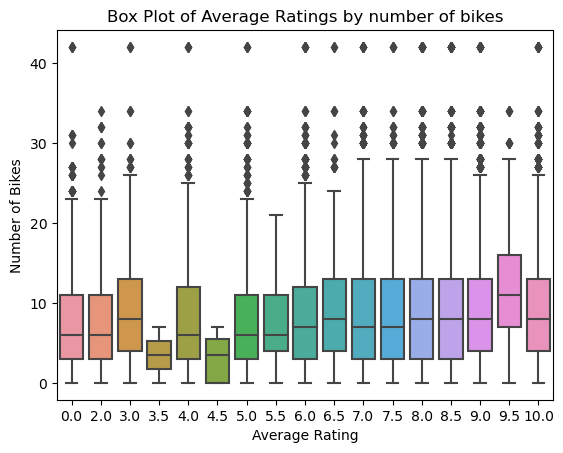

In [709]:
# Create a boxplot of the Average POI ratings by the number of bikes at the station.
# I made sure to round all the ratings to the nearest 0.5 first in order to minimize the number of boxes.

sns.boxplot(x=round(POI_df['avg rating'] * 2) / 2, y=POI_df['number of bikes'])
plt.xlabel('Average Rating')
plt.ylabel('Number of Bikes')
plt.title('Box Plot of Average Ratings by number of bikes')
plt.show()

#### Looking at our chart, there is no discernable correlation between the weighted average of a single POI to the number of bikes at the bike stations nearby

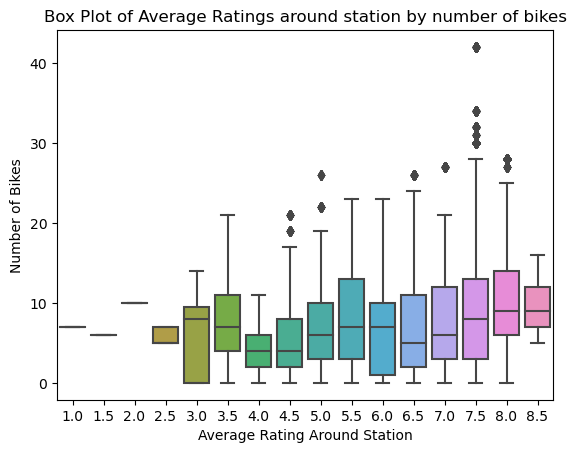

In [710]:
# Create a boxplot of the Average Ratings around a station by the number of bikes at the station.
# I made sure to round all the ratings to the nearest 0.5 first in order to minimize the number of boxes.

sns.boxplot(x=round(POI_df['avg_rating_around_station'] * 2) / 2, y=POI_df['number of bikes'])
plt.xlabel('Average Rating Around Station')
plt.ylabel('Number of Bikes')
plt.title('Box Plot of Average Ratings around station by number of bikes')
plt.show()

#### Once again, I can't really discern whether there is a correlation here, but it appears that there may be some positive correlation between the average ratings aorund a station and the number of bikes at the station.

###  Let's try a scatter plot between FS_rating and yelp_rating to see how these relate

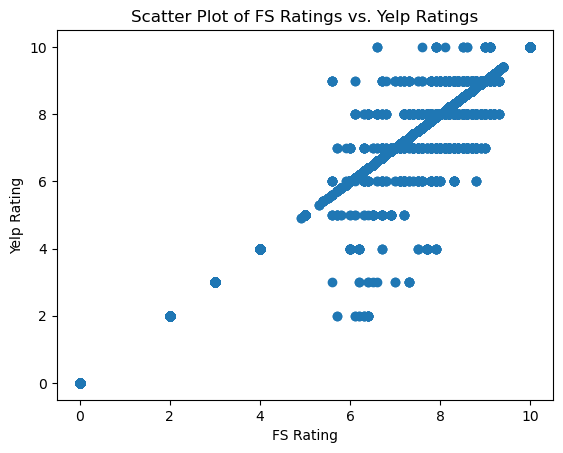

In [711]:
plt.scatter(POI_df['FS_rating'], POI_df['yelp_rating'])
plt.xlabel('FS Rating')
plt.ylabel('Yelp Rating')
plt.title('Scatter Plot of FS Ratings vs. Yelp Ratings')
plt.show()

#### The straight diagonal line (as exciting as that is) can be ignored here because we had copied the FS_ratings to yelp_ratings when they were missing before, so that's what we are observing there.  Aside from those points, there is not as much of a correlation between FS_rating and yelp_rating as I would have expected there to be.  Although, they do appear to have a weak positive correlation.

### Let's try comparing yelp_price_rating and FS_price_rating to the number of bikes separately

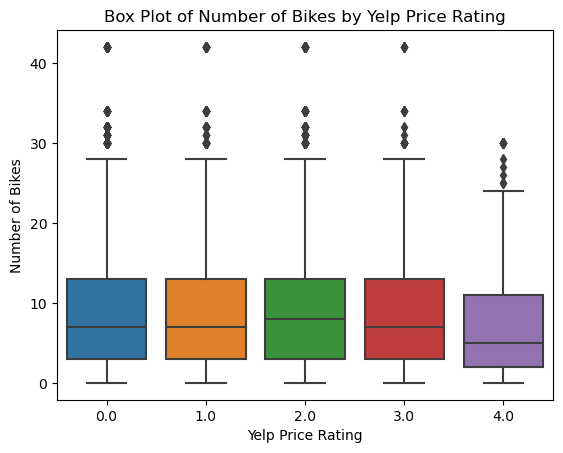

In [712]:
sns.boxplot(x=POI_df['yelp_price_rating'], y=POI_df['number of bikes'])
plt.xlabel('Yelp Price Rating')
plt.ylabel('Number of Bikes')
plt.title('Box Plot of Number of Bikes by Yelp Price Rating')
plt.show()

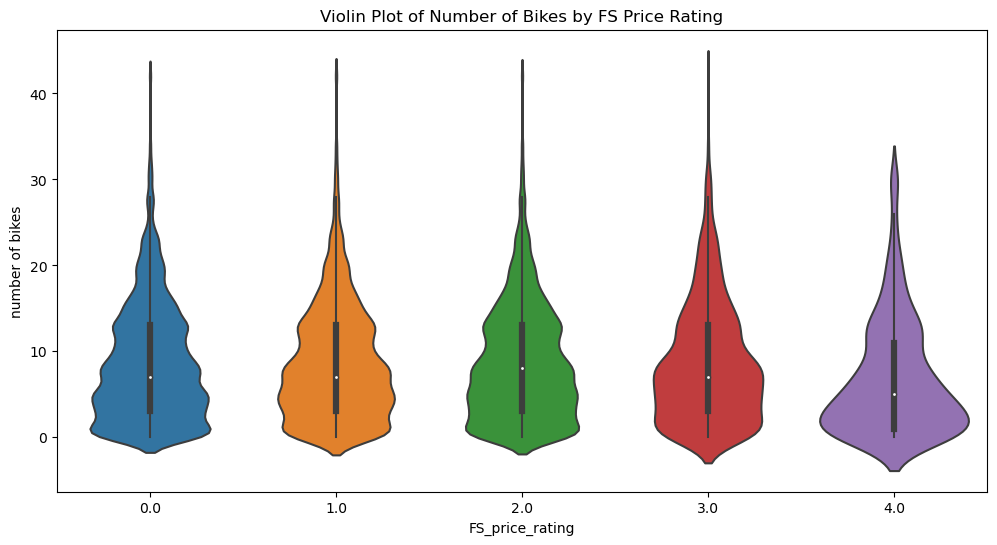

In [713]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=POI_df, x='FS_price_rating', y='number of bikes')
plt.title("Violin Plot of Number of Bikes by FS Price Rating")
plt.show()

#### There appears to be some negative correlation between the FS_price_rating and the number of bikes, albeit pretty small.

### Finally, let's create a correlation matrix between all of the qualitative values and a pairplot between our engineered values and the number of bikes

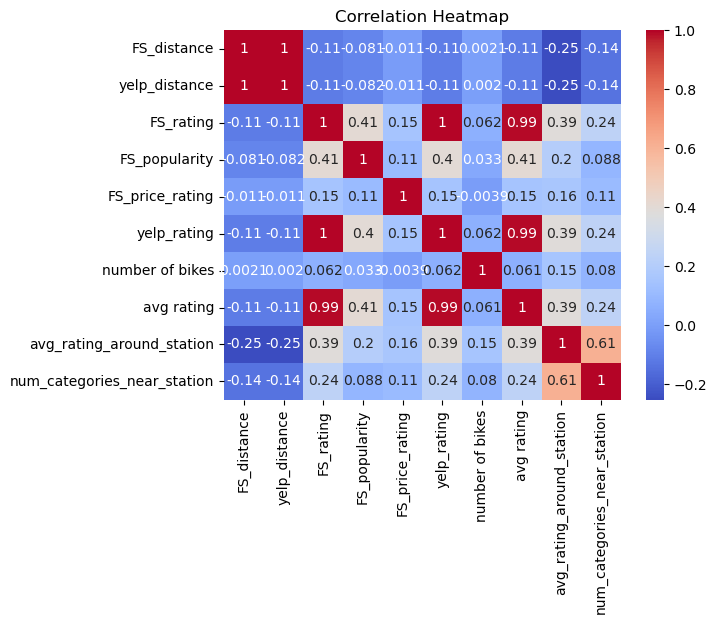

In [714]:
POI_df_measures = POI_df[['FS_distance', 'yelp_distance', 'FS_rating', 'FS_popularity','FS_price_rating','yelp_rating', 'number of bikes',
                          'avg rating','avg_rating_around_station','num_categories_near_station']]
correlation_matrix = POI_df_measures.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### Focusing in on the number of bikes correlations, we can see our strongest correlations with the engineered values, even though these correlation values are quite low.  We also see some small correlation with avg rating, FS_rating, yelp_rating, and FS_popularity.

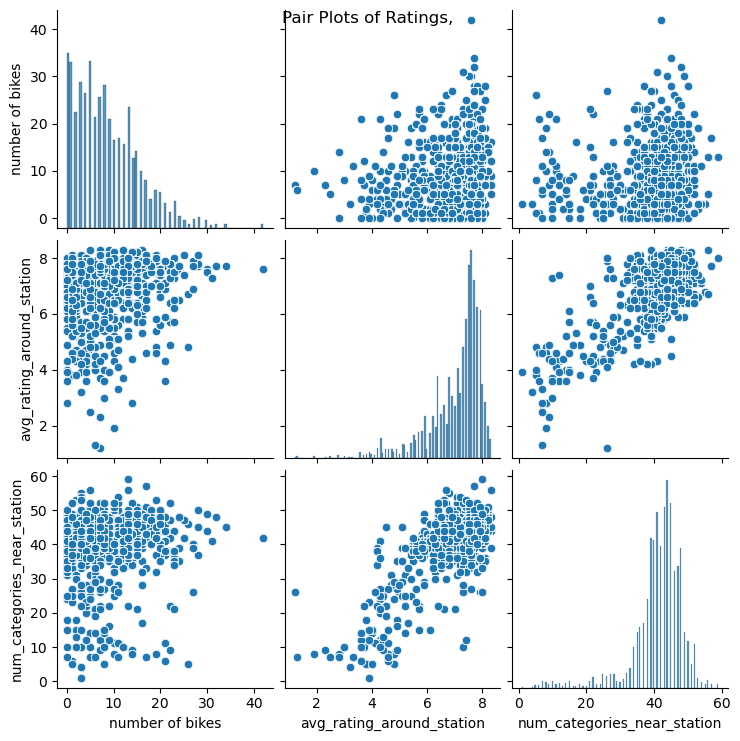

In [715]:
sns.pairplot(POI_df[['number of bikes', 'avg_rating_around_station', 'num_categories_near_station']])
plt.suptitle('Pair Plots of Ratings, ')
plt.show()

## Other Exploration Performed:

### I've included a journey I took into the data to determine what the top categories were surrounding each station and then created a count of all of how many POIs in these categories were near each station. I didn't end up having the time to use this data frame, but thought it'd be useful if/when I come back to this project.

In [716]:
# For every category represented in the dataframe, we count the total number of the bikes "surrounding" that category.

category_count = {}

for row, index in POI_df.iterrows():
    row_cat_list = []
    
    if isinstance(index['FS_categories'], str):    
        for category in ast.literal_eval(index['FS_categories']):
            if category not in row_cat_list:
                row_cat_list.append(category)
                if category not in category_count:
                    category_count[category] = index['number of bikes']
                else:
                    category_count[category] += index['number of bikes']
            else:
                pass

    if isinstance(index['yelp_categories'], str):
        for category in ast.literal_eval(index['yelp_categories']):    
            if category not in row_cat_list:
                row_cat_list.append(category)
                if category not in category_count:
                    category_count[category] = index['number of bikes']
                else:
                    category_count[category] += index['number of bikes']
            else:
                pass

In [717]:
# Create a list of tuples to turn into a DF for category and count
bikes_per_category_data = [(category, count) for category, count in category_count.items()]

# Create a DataFrame from the processed data
bikes_per_category = pd.DataFrame(bikes_per_category_data, columns=['categories', 'bike count'])
bikes_per_category.sort_values(by = 'bike count', ascending=False)

,categories,bike count
1,Restaurant,43354
21,Coffee & Tea,36835
19,Coffee Shop,21979
186,Pizza,21237
0,Café,21179
...,...,...
531,Peking Duck Restaurant,2
561,Barbershop,2
538,Psychic and Astrologer,2
460,Rental Car Location,1


In [718]:
# We can see that the above data doesn't make sense, because there aren't even 43000 bikes to begin with, so we know there are multiple
# duplicate counts for each category.  However, if we turn this into a percentage of bikes represented per category, it gives a better
# picture of which categories has the most bikes surrounding it.
total_count = 0
for row, index in bikes_per_category.iterrows():
    total_count += index['bike count']

bikes_per_category['bike percentage'] = bikes_per_category['bike count'] *100 / total_count

In [719]:
bikes_per_category.sort_values(by = 'bike count', ascending=False).head(20)

,categories,bike count,bike percentage
1,Restaurant,43354,5.069286
21,Coffee & Tea,36835,4.307034
19,Coffee Shop,21979,2.569955
186,Pizza,21237,2.483195
0,Café,21179,2.476413
32,Bakeries,19075,2.230397
14,Sandwiches,18810,2.199411
139,Fast Food,16953,1.982276
167,Breakfast & Brunch,14260,1.667390
204,Italian,13145,1.537015


### This information at least lets me know what the "top categories" are.  So what I'd like to do is make a category count around each station for just the top 10 categories.  I will, however, combine some of these top categories into a single category since many are essentially the same thing.
#### My top 10 categories would then be:
##### 1) Restaurant 
##### 2) Cafe
##### 3) Pizza
##### 4) Bakery
##### 5) Sandwich
##### 6) Fast Food
##### 7) Desserts
##### 8) Bar
##### 9) Burgers
##### 10) Park

In [720]:
# Lists of the top 10 categories along with associated category words
restaurant = ['Restaurant', 'Breakfast & Brunch', 'Italian'] # index in list = 0
cafe = ['Coffee & Tea', 'Coffee Shop', 'Cafe'] # index in list = 1
pizza = ['Pizza'] # index in list = 2
bakery = ['Bakery'] # index in list = 3
sandwich = ['Sandwiches'] # index in list = 4
fastfood = ['Fast Food'] # index in list = 5
desserts = ['Desserts'] # index in list = 6
bar = ['Bar', 'Bars'] # index in list = 7
burgers = ['Burgers'] # index in list = 8
park = ['Park'] # index in list = 9

#create a list of all station_ids so we can use for our dictionary keys.
station_id_list = POI_df.station_id.unique()

# Initialize our dictionary that we will later turn into a dataframe
cat_count_per_station = {key: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] for key in station_id_list}


for row, index in POI_df.iterrows():
    if isinstance(index['FS_categories'], str):    
        for category in ast.literal_eval(index['FS_categories']):
            if category in restaurant:
                cat_count_per_station[index['station_id']][0] += 1
            elif category in cafe:
                cat_count_per_station[index['station_id']][1] += 1
            elif category in pizza:
                cat_count_per_station[index['station_id']][2] += 1
            elif category in bakery:
                cat_count_per_station[index['station_id']][3] += 1
            elif category in sandwich:
                cat_count_per_station[index['station_id']][4] += 1
            elif category in fastfood:
                cat_count_per_station[index['station_id']][5] += 1
            elif category in desserts:
                cat_count_per_station[index['station_id']][6] += 1
            elif category in bar:
                cat_count_per_station[index['station_id']][7] += 1
            elif category in burgers:
                cat_count_per_station[index['station_id']][8] += 1
            elif category in park:
                cat_count_per_station[index['station_id']][9] += 1
            else:
                pass

    if isinstance(index['yelp_categories'], str):    
        for category in ast.literal_eval(index['yelp_categories']):
            if category in restaurant:
                cat_count_per_station[index['station_id']][0] += 1
            elif category in cafe:
                cat_count_per_station[index['station_id']][1] += 1
            elif category in pizza:
                cat_count_per_station[index['station_id']][2] += 1
            elif category in bakery:
                cat_count_per_station[index['station_id']][3] += 1
            elif category in sandwich:
                cat_count_per_station[index['station_id']][4] += 1
            elif category in fastfood:
                cat_count_per_station[index['station_id']][5] += 1
            elif category in desserts:
                cat_count_per_station[index['station_id']][6] += 1
            elif category in bar:
                cat_count_per_station[index['station_id']][7] += 1
            elif category in burgers:
                cat_count_per_station[index['station_id']][8] += 1
            elif category in park:
                cat_count_per_station[index['station_id']][9] += 1
            else:
                pass
    
# Transform the data into lists that we will use to construct our DataFrame
transformed_data = []
for key, values in cat_count_per_station.items():
    row = [key] + values
    transformed_data.append(row)

# Create the DataFrame
column_names = ['station_id', 'Restaurant', 'Cafe', 'Pizza', 'Bakery', 'Sandwich', 'Fast Food', 'Desserts', 'Bar', 'Burgers', 'Park']
top_cat_count_per_station_df = pd.DataFrame(transformed_data, columns=column_names)

top_cat_count_per_station_df

,station_id,Restaurant,Cafe,Pizza,Bakery,Sandwich,Fast Food,Desserts,Bar,Burgers,Park
0,7000,15,20,0,0,5,3,2,4,1,4
1,7001,11,14,1,1,1,3,4,3,2,2
2,7002,15,13,2,1,2,1,0,4,2,3
3,7003,13,12,2,1,0,1,2,3,2,3
4,7004,10,13,2,0,9,4,0,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...
684,7816,11,13,1,0,2,2,3,1,0,1
685,7817,18,9,5,7,2,5,1,5,3,1
686,7818,12,13,4,2,0,4,4,4,5,1
687,7819,5,8,5,1,3,3,1,5,2,2


In [721]:
# This new dataframe is not necessarily useful to include in the "bigger dataframe" in its current form, but I'll add the number of bikes
# at each station to this dataframe so I can try to build a regression model from this one separately.

top_cat_count_per_station_df['number of bikes'] = df_tbs['number of bikes']

top_cat_count_per_station_df.head()

,station_id,Restaurant,Cafe,Pizza,Bakery,Sandwich,Fast Food,Desserts,Bar,Burgers,Park,number of bikes
0,7000,15,20,0,0,5,3,2,4,1,4,34
1,7001,11,14,1,1,1,3,4,3,2,2,16
2,7002,15,13,2,1,2,1,0,4,2,3,3
3,7003,13,12,2,1,0,1,2,3,2,3,4
4,7004,10,13,2,0,9,4,0,2,1,2,0


In [722]:
# Save this dataframe as a csv
top_cat_count_per_station_df.to_csv('../data/top_cat_count_per_station.csv', index=False)

# Database Creation

In [723]:
import pandas as pd
import sqlite3
from sqlite3 import Error

### Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [724]:
# Create an SQLite database and connect to it
conn = sqlite3.connect('../data/stationpois.db')

# Write the DataFrame to the SQLite database
POI_df.to_sql('StationPOIInfo', conn, if_exists='replace', index=False)

# Close the connection
conn.close()


### Double check the table in our database to the original dataframe to make sure it was created correctly.

In [725]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [726]:
connection = create_connection("../data/stationpois.db")

Connection to SQLite DB successful


In [727]:
# Connect to the SQLite database
conn = sqlite3.connect('../data/stationpois.db')

# Define the query to fetch the first 10 rows from the table
query = "SELECT * FROM StationPOIInfo"

# Fetch data from the database
data_from_db = conn.execute(query).fetchall()

# Close the connection
conn.close()

# Create a DataFrame from the fetched data
column_names = POI_df.columns
df_from_db = pd.DataFrame(data_from_db, columns=column_names)

In [728]:
# Display the first 5 rows of the original DataFrame
POI_df.head()

,POI_name,FS_id,station_id,POI_latitude,POI_longitude,FS_distance,FS_categories,FS_rating,FS_total_ratings,FS_popularity,...,yelp_total_ratings,yelp_price_rating,yelp_tastes,station_name,station_latitude,station_longitude,number of bikes,avg rating,avg_rating_around_station,num_categories_near_station
0,CAFE Dispensary,59d19c050c9f3155d662a0c8,7000,43.640,-79.396,40.0,['Café'],7.8,8.0,0.826702,...,8.0,1.0,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.800000,7.7,45
1,Hunters Landing,523a2355498e1d680be63936,7000,43.640,-79.397,69.0,"['Restaurant', 'Bar']",7.4,184.0,0.963629,...,236.0,2.0,"['comfortfood', 'bars', 'newcanadian']",Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.175238,7.7,45
2,Sansotei Ramen,5b12b96b31ac6c00397662c0,7000,43.639,-79.398,193.0,['Ramen Restaurant'],8.5,21.0,0.913721,...,94.0,2.0,['ramen'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,8.091304,7.7,45
3,Canoe Landing Park,4bdde5056198c9b61a1c12ff,7000,43.639,-79.397,148.0,['Park'],7.6,33.0,0.984278,...,11.0,0.0,['parks'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.450000,7.7,45
4,Roywoods,56f6ee66498e7f811a135ddd,7000,43.639,-79.399,216.0,"['Caribbean Restaurant', 'Sandwich Spot']",8.3,15.0,0.945704,...,15.0,2.0,NaN,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,8.300000,7.7,45


In [729]:
# Display the first 5 rows of the DataFrame constructed from the database
df_from_db.head()

,POI_name,FS_id,station_id,POI_latitude,POI_longitude,FS_distance,FS_categories,FS_rating,FS_total_ratings,FS_popularity,...,yelp_total_ratings,yelp_price_rating,yelp_tastes,station_name,station_latitude,station_longitude,number of bikes,avg rating,avg_rating_around_station,num_categories_near_station
0,CAFE Dispensary,59d19c050c9f3155d662a0c8,7000,43.640,-79.396,40.0,['Café'],7.8,8.0,0.826702,...,8.0,1.0,None,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.800000,7.7,45
1,Hunters Landing,523a2355498e1d680be63936,7000,43.640,-79.397,69.0,"['Restaurant', 'Bar']",7.4,184.0,0.963629,...,236.0,2.0,"['comfortfood', 'bars', 'newcanadian']",Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.175238,7.7,45
2,Sansotei Ramen,5b12b96b31ac6c00397662c0,7000,43.639,-79.398,193.0,['Ramen Restaurant'],8.5,21.0,0.913721,...,94.0,2.0,['ramen'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,8.091304,7.7,45
3,Canoe Landing Park,4bdde5056198c9b61a1c12ff,7000,43.639,-79.397,148.0,['Park'],7.6,33.0,0.984278,...,11.0,0.0,['parks'],Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,7.450000,7.7,45
4,Roywoods,56f6ee66498e7f811a135ddd,7000,43.639,-79.399,216.0,"['Caribbean Restaurant', 'Sandwich Spot']",8.3,15.0,0.945704,...,15.0,2.0,None,Fort York Blvd / Capreol Ct,43.639832,-79.395954,34,8.300000,7.7,45


In [730]:
if POI_df.shape == df_from_db.shape:
    print('The original dataframe is the same size as the dataframe made from the database')
else:
    print('Oops.  Something went wrong in the creation of your database')

The original dataframe is the same size as the dataframe made from the database


### It looks like our database creation was successful!

## Saving our final version of POI_df as a csv

In [731]:
POI_df.to_csv('../data/POI_df.csv', index=False)